# Closed Loop: Basics

## Import necessary Python modules

In [1]:
import numpy as np
import epics # 'epics' is part of pyepics
from epics import PV
from time import sleep
import matplotlib.pyplot as plt

## Establish initial settings for LEDs, Photodetector, and Shutter

In [2]:
epics.caput("SHUTTER:enable", 0) # Disable the shutter

NLEDS = 6 # our sidekick system has six LEDs
for i in range(NLEDS): # for each of our six LEDs
    epics.caput('LEDS:CH' + str(i) + ':brig.VAL', 255) # Set LED brightness to 255 out of 255 (max brightness)
    epics.caput('LEDS:CH' + str(i) + ':dur.VAL', 30.0e3) # Set LED 'flash on' duration to 30 ms

epics.caput("PHOTO:dur", 100.0e3) # Set photodetector exposure time to 100 ms
epics.caput("PULSEGEN:CH0:delay", 5.0e3) # Set LED trigger delay to 5 ms
epics.caput("PULSEGEN:CH2:delay", 0.0e3) # Set Photodetector trigger delay to 0 ms
epics.caput("PULSEGEN:reprate", 3) # Set systemwide repetition rate to 3 Hz

1

## Write parser to interpret photodetector data string

In [3]:
def dataparse(datastr):
    """ Parse the photodetector data string, which comes in the format 'DAT: 0.02112776, TRIG: 531' """
    [str1, str2] = datastr.split(',')
    data = np.float64(str1.split(': ')[1])
    trig = np.int64(str2.split(': ')[1])
    return data, trig

# Example usage:
dataparse("DAT: 0.009594346400, TRIG: 11")

(0.0095943464, 11)

In [4]:
pvphoto = PV("PHOTO:data.VAL", form="time")

In [5]:
dataparse(pvphoto.value)

(0.002659461, 6337)

## Explore a Closed Loop

In [6]:
def fancyFeedbackAlgo(brightness, signal, target_signal):
    """ Suggests next brightness value to try based on the present photodiode signal 

    brightness:        Current LED brightness
    signal:            Corresponding photodiode signal
    target_signal:     Desired photodiode signal
    
    next_brightness:   Suggested next brightness value to try
    """
    
    if signal < target_signal:
        next_brightness = brightness + 15 # increase brightness next time
    else:
        next_brightness = brightness - 15 # decrease brightness next time
    
    next_brightness = np.clip(next_brightness, 0, 255) # constrain values to valid range
    
    return next_brightness

In [7]:
NSTEPS = 20 # We will let this feedback algorithm run for 20 distinct steps

brigs = np.zeros(NSTEPS, dtype="int64") # allocate array to hold LED brightness corresponding to each photodetector value
data = np.zeros(NSTEPS) # allocate array to hold photodetector value for each brightness step
trigs = np.zeros(NSTEPS, dtype='int64') # allocate array to hold trigger count corresponding to each photodetector value

isfresh = False # isfresh is a global variable indicating fresh data is ready to take

def dataCallback(**kw):
    global isfresh
    isfresh = True

pvphoto.add_callback(dataCallback)

sig_init, trig = dataparse(pvphoto.value)
sig_target = sig_init / 2.0 # Set target signal level to half of the current signal level
brig = 255

for i in range(NSTEPS):
    brigs[i] = brig
    print("Brightnes: ", brig)
    for j in range(NLEDS): # for each of our six LEDs
        epics.caput('LEDS:CH' + str(j) + ':brig.VAL', brig) # Set LED brightness to 255 out of 255 (max brightness)
    isfresh = False
    while not isfresh:
        sleep(0.1)
    data[i], trigs[i] = dataparse(pvphoto.value)
    print("Trigger: ", trigs[i])
    print("Signal: ", data[i])
    next_brig = fancyFeedbackAlgo(brig, data[i], sig_target)
    brig = next_brig

pvphoto.clear_callbacks()

Brightnes:  255
Trigger:  6340
Signal:  0.0026838379
Brightnes:  240
Trigger:  6343
Signal:  0.0024844671
Brightnes:  225
Trigger:  6347
Signal:  0.0023077673
Brightnes:  210
Trigger:  6350
Signal:  0.0021284001
Brightnes:  195
Trigger:  6354
Signal:  0.0019022856
Brightnes:  180
Trigger:  6357
Signal:  0.001718323
Brightnes:  165
Trigger:  6361
Signal:  0.00153772
Brightnes:  150
Trigger:  6364
Signal:  0.0013247227
Brightnes:  165
Trigger:  6368
Signal:  0.0014969482
Brightnes:  150
Trigger:  6371
Signal:  0.0013220519
Brightnes:  165
Trigger:  6375
Signal:  0.0015684342
Brightnes:  150
Trigger:  6378
Signal:  0.0013821451
Brightnes:  135
Trigger:  6382
Signal:  0.0011724865
Brightnes:  150
Trigger:  6385
Signal:  0.0013828129
Brightnes:  135
Trigger:  6389
Signal:  0.0012252349
Brightnes:  150
Trigger:  6392
Signal:  0.0013855938
Brightnes:  135
Trigger:  6396
Signal:  0.0012432629
Brightnes:  150
Trigger:  6399
Signal:  0.0013621141
Brightnes:  135
Trigger:  6403
Signal:  0.0011698

## Plot results

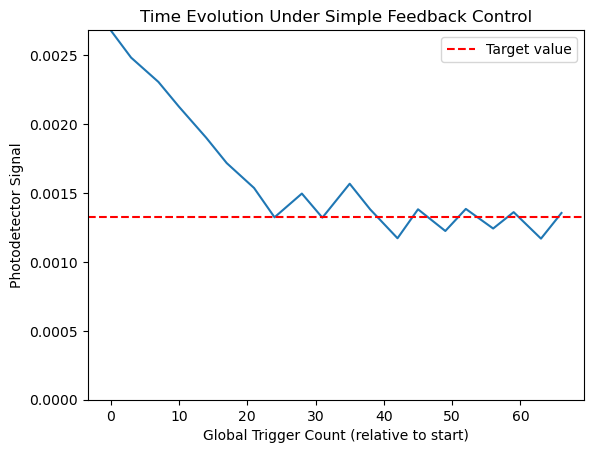

In [11]:
fig, ax = plt.subplots()
ax.plot(trigs - trigs[0], data)
ax.axhline(sig_target, color='red', linestyle='--', label="Target value")
ax.set_ylim([0, np.max(data)])
ax.set_title("Time Evolution Under Simple Feedback Control")
ax.set_ylabel("Photodetector Signal")
ax.set_xlabel("Global Trigger Count (relative to start)")
plt.legend()
plt.show()